<a href="https://colab.research.google.com/github/IrisFDTD/AI-UNIZAR-course/blob/main/deltas/ai_unizar_course_deltas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Licencia Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">*Introducción a la inteligencia artificial: redes neuronales avanzadas con Tensorflow-Keras*</span> por <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Sergio Gutiérrez Rodrigo (sergut@unizar.es)</span> se distribuye bajo una <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Licencia Creative Commons Atribución-NoComercial-CompartirIgual 4.0 Internacional</a>. *This Jupyter notebook has been adapted from a code written by Luis Martin Moreno (lmm@unizar.es).*

```
Sergio G Rodrigo
Departamento de Física Aplicada
Universidad de Zaragoza
Instituto de Nanociencia y Materiales de Aragón (INMA)
C/ Pedro Cerbuna, 12, 50009, Zaragoza, España
```






# **Advanced Neural Networks with TensorFlow-Keras**

---
# **Replace numerical methods with neural networks: denoising autoencoders**
---


#  Transmission and reflection of an electron through a potential barrier

An electron that propagates from $-\infty$ to $+\infty$ with energy $E$ (i.e., with a wave number $k$ such that $E = \frac{{\hbar^2k^2}}{{2m}}$ can be partially reflected and transmitted by a energy potential.  

The wave solution is:

$\psi(x) = e^{ikx} + r(k) e^{-ikx}$ for $x < -1$,

$\psi(x) = t(k) e^{ikx}$ for $x > 1$.

The reflection and transmission coefficients ($r(k)$ and $t(k)$, respectively). From these coefficients, we can extract the reflectance $R(k) = |r(k)|^2$ and the transmittance $T(k) = |t(k)|^2$.

*Example of an electron interacting with two Dirac's deltas:*

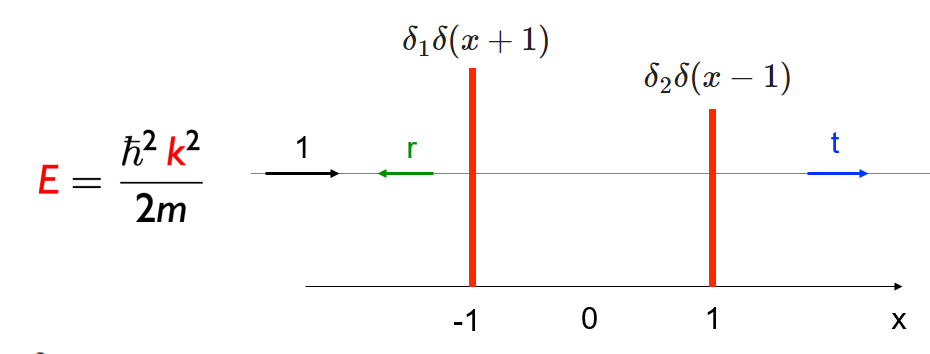

# Mount Google Drive (local uploading)

In [ ]:
#Your google drive is made accesible to Colab.
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd /content/drive/MyDrive/docencia_2023-2024/curso_IA_2023-2024/AI-UNIZAR-course-github/deltas/
    %ls -lht
    # To import own packages set local path in packages syspath
    import sys
    sys.path.insert(0,"./")
except ImportError:
    print("You are not in google.colab!!")
    pass

# Clone from Github (remote uploading)

In [ ]:
# Install Git (if not already installed)
!apt-get -q install git

# Replace placeholders with actual values
username = "IrisFDTD"
repository = "AI-UNIZAR-course"

# Clone the repository
repo_url = f"https://@github.com/{username}/{repository}.git"
!git clone {repo_url}

%cd {repository}
%cd ./deltas/
%ls -lht

# Main imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras import Model,Sequential
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.optimizers import  Adam

# Auxiliary functions

In [3]:
def plot_history(history):
    train_loss = history.history['loss']
    epochs = range(1, len(train_loss) + 1)

    # Extract the validation loss values
    val_loss = history.history['val_loss']

    # Plot the training loss and validation loss vs. epoch
    plt.rcParams.update({'font.size': 14})
    # Set the y-axis to logarithmic scale
    plt.yscale('log')
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    pass

# Load data

+ Potential: two Dirac deltas located at positions $x = -1$ and $x = -1$, so
$V(x) = \delta_1 \delta(x + 1) + \delta_2 \delta(x - 1)$.
+ $\delta_1$ and $\delta_2$ are free parameters to be chosen, which defines the whole scattering response.
+ Synthetic data has been prepared by choosing 10,000 random values for the pair ($\delta_1, \delta_2$), where each value of $\delta_1, \delta_2$ can vary between 0 and 5, and calculating for each pair $T(\delta_1, \delta_2, k)$ for 300 equidistant values of $k$ ranging from 0 to 10.
+ Here, $\hbar$ and $m$ are the Planck constant and electron mass, respectively (in the calculation, we choose a system of units where $\hbar = m = 1$).
+ Data structure:
  - *TRANS_2delta.csv*: [$T(k_1)$ ]; ...; [$T(k_n)$]
  - *DELTAS_2delta.csv*: [$\delta_1$];[$\delta_2$]


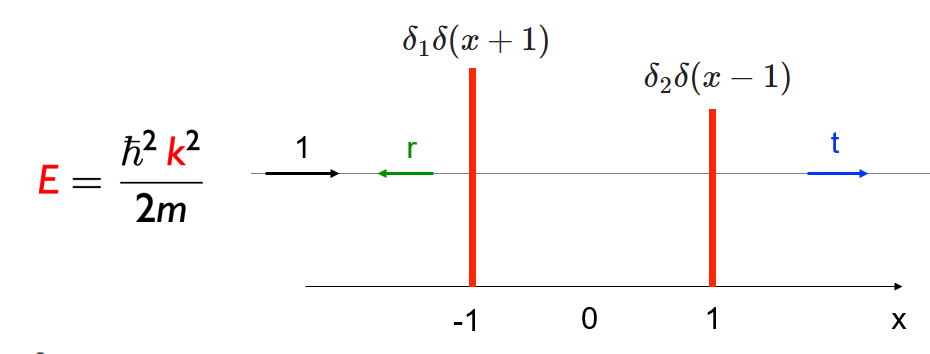

In [4]:
filex = 'TRANS_2delta.csv'
filey = 'DELTAS_2delta.csv'

X = pd.read_csv(filex, header = None)
y = pd.read_csv(filey, header = None)

value_trans_0, value_deltas_sin_normalizar =np.array(X),np.array(y)
value_deltas = value_deltas_sin_normalizar/np.max(value_deltas_sin_normalizar)

disorder = 2 * (np.random.rand(value_trans_0.shape[0], value_trans_0.shape[1])-0.5)
value_trans = value_trans_0 + disorder * value_trans_0 * (1-value_trans_0)

#Set the training and validation data

In [5]:
ntrain0 = 8000
nvalidation0 = 2000
ndata = ntrain0 + nvalidation0

# Transmission without noise (original)
yva_0 = value_trans_0[ntrain0:ntrain0 + nvalidation0, :]
nok=yva_0.shape[1] # Numbero of k's

# Noisy transmission
# Inputs (x) and outputs (y) the same for autoencoders
y = value_trans

# Training and validation datasets
ytr = y[0:ntrain0,:]
yva = y[ntrain0:ntrain0 + nvalidation0, :]

# Epochs, hyperparameters, optimizer, loss and initializers

In [6]:
# Epochs
epochs = 50

# Hyperparameters
minib_size = 10
eta = 0.001

# Define the loss and optimizer
loss_function = 'mse'
opt = Adam(eta)

# kernel and bias initialization
kernel_init = tf.keras.initializers.GlorotNormal()
bias_init =   tf.keras.initializers.GlorotUniform()


# Define  the autoencoder

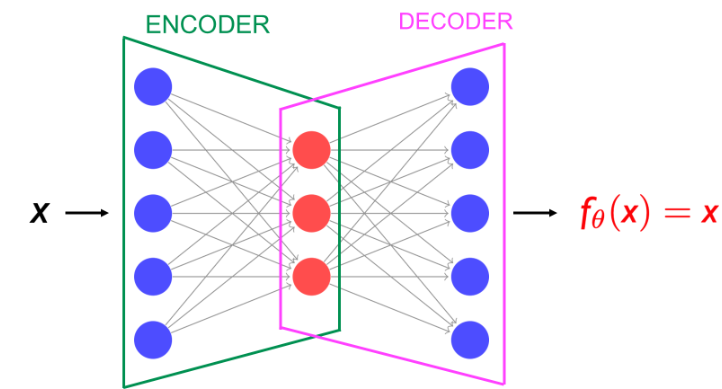

In [7]:
nneurons = 200
nn2 = 50
nnmin = 2 # Neurons latent space

# Encoder
input_encoder = Input(shape=ytr.shape[1])
x = Dense(nneurons, activation='relu')(input_encoder)
x = Dense(nn2, activation='relu')(x)
latent_layer = Dense(nnmin, activation='relu')(x)
encoder=Model(input_encoder,latent_layer)
encoder.summary()

# Decoder
input_decoder = Input(shape=latent_layer.shape)
x = Dense(nn2, activation='relu')(input_decoder)
x = Dense(nneurons, activation='relu')(x)
output = Dense(ytr.shape[1], activation='sigmoid',\
                          kernel_initializer = kernel_init,\
                          bias_initializer = bias_init)(x)
decoder=Model(input_decoder,output)
decoder.summary()

# Autoencoder
model =Sequential([encoder,decoder])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 dense (Dense)               (None, 200)               60200     
                                                                 
 dense_1 (Dense)             (None, 50)                10050     
                                                                 
 dense_2 (Dense)             (None, 2)                 102       
                                                                 
Total params: 70352 (274.81 KB)
Trainable params: 70352 (274.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input

# Run the autoencoder

Epoch 1/50
800/800 [==============================] - 7s 4ms/step - loss: 0.0232 - val_loss: 0.0141
Epoch 2/50
800/800 [==============================] - 5s 6ms/step - loss: 0.0127 - val_loss: 0.0117
Epoch 3/50
800/800 [==============================] - 4s 4ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 4/50
800/800 [==============================] - 3s 4ms/step - loss: 0.0110 - val_loss: 0.0108
Epoch 5/50
800/800 [==============================] - 3s 4ms/step - loss: 0.0109 - val_loss: 0.0108
Epoch 6/50
800/800 [==============================] - 4s 6ms/step - loss: 0.0094 - val_loss: 0.0089
Epoch 7/50
800/800 [==============================] - 3s 4ms/step - loss: 0.0088 - val_loss: 0.0087
Epoch 8/50
800/800 [==============================] - 3s 4ms/step - loss: 0.0088 - val_loss: 0.0087
Epoch 9/50
800/800 [==============================] - 3s 4ms/step - loss: 0.0088 - val_loss: 0.0087
Epoch 10/50
800/800 [==============================] - 5s 6ms/step - loss: 0.0087 - val_loss: 0.0087

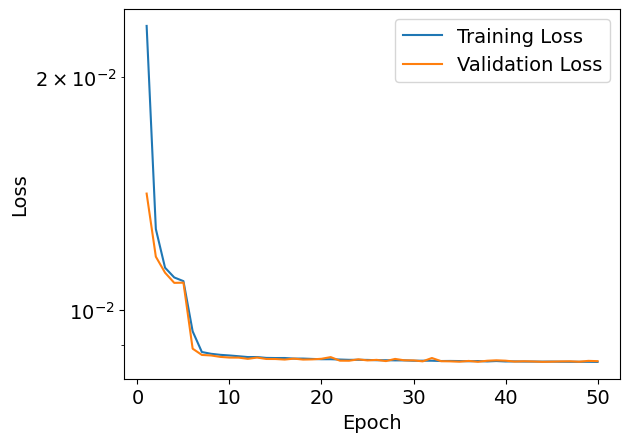

In [8]:
# Compile and fit
model.compile(optimizer=opt, loss=loss_function)

# Inputs (x) and outputs (y) the same for autoencoders
history = model.fit(ytr, ytr, batch_size = minib_size, epochs=epochs,
              validation_data=(yva, yva))

plot_history(history)

# Check the autoencoder

63/63 [==============================] - 0s 3ms/step
index: 509


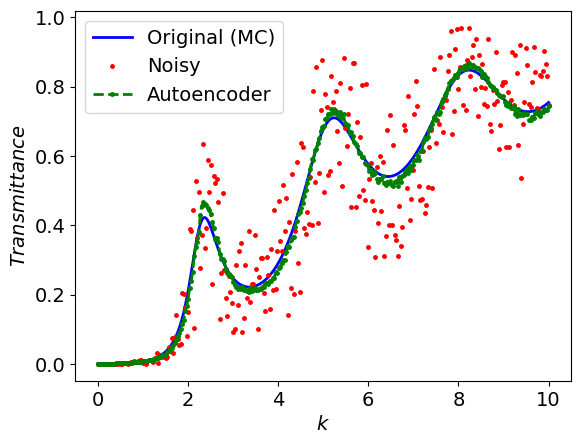

In [9]:
NN_ytr = model.predict(ytr)
NN_yva = model.predict(yva)
nok=yva_0.shape[1]
k=np.linspace(0,10.0,nok)

# Random picked spectrum in validation
j=np.random.randint(int(NN_yva.shape[0]))
print('index:',j)

# Plot
plt.plot(k,yva_0[j], color="blue", fillstyle='none',linewidth=2, marker='.', markersize=0,label='Original (MC)')
plt.plot(k,yva[j], color="red", linewidth=0, marker='.', markersize=5,label='Noisy')
plt.plot(k,NN_yva[j], color="green", linewidth=2, linestyle='--',marker='.', markersize=5,label='Autoencoder')
plt.xlabel('$k$')
plt.ylabel('$Transmittance$')
plt.legend()
plt.show()

# Decoder: spectra generator

In [10]:
layers={}
for i,layer in enumerate(decoder.layers):
  print("layer"+str(i))
  print("name=",layer.name)
  print("input_shape=",layer.input_shape)
  print("output_shape=",layer.output_shape)
  layers["layer"+str(i)]=layer

layer0
name= input_2
input_shape= [(None, None, 2)]
output_shape= [(None, None, 2)]
layer1
name= dense_3
input_shape= (None, None, 2)
output_shape= (None, None, 50)
layer2
name= dense_4
input_shape= (None, None, 50)
output_shape= (None, None, 200)
layer3
name= dense_5
input_shape= (None, None, 200)
output_shape= (None, None, 300)


(None, None, 2)
[[0.28564471 0.87643483]]
1/1 [==============================] - 0s 87ms/step


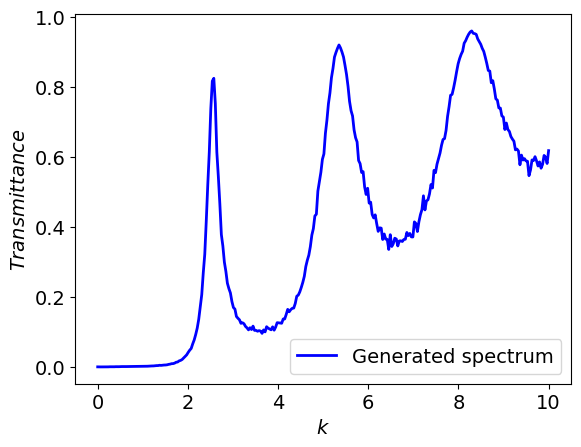

In [11]:
shape=layers["layer1"].input_shape
print(shape)
x=np.random.rand(1,2)
print(x)
spectra_gen=np.squeeze(decoder.predict(x))

# Plot
plt.plot(k,spectra_gen, color="blue", fillstyle='none',linewidth=2, marker='.', markersize=0,label='Generated spectrum')
plt.xlabel('$k$')
plt.ylabel('$Transmittance$')
plt.legend()
plt.show()

# Appendix: Quantum Scattering Theory

In the following example synthetic data is used (created from a mathematical model). It is consider the quantum transmission of an electron moving in one dimension in the presence of a potential $V(x)$ that is zero throughout space except at $x \in [-l, l]$, where it has an arbitrary shape (we set $l = 1$ for the rest of the work). We know that stationary wave functions $\psi(x)$ with associated energy $E$ satisfy the time-independent Schrödinger equation:
$$
\begin{equation}
-\frac{\hbar^2}{2m} \frac{d^2\psi}{dx^2} + V(x)\psi(x) = E\psi(x)
\end{equation}
$$
The free-wave solutions in the domain $x \notin [-l, l]$ are given by a linear combination of the functions $e^{ikx}$ and $e^{-ikx}$, where $k = \frac{\sqrt{2mE}}{\hbar}$ is the wave number. These represent states with well-defined linear momentum traveling in the positive and negative directions of the $x$-axis, respectively.

For $x < -l$, we have
\begin{equation}
\psi(x) = Ae^{ikx} + A'e^{-ikx}
\end{equation}
while for $x > l$, we have
\begin{equation}
\psi(x) = \tilde{A}e^{ikx} + \tilde{A'}e^{-ikx}
\end{equation}

The transmission matrix $M$ relates the wave amplitudes $A$ and $A'$ at $x < -l$ to the amplitudes $\tilde{A}$ and $\tilde{A'}$ at $x > l$ as follows:
\begin{equation}
\begin{pmatrix}
\tilde{A} \\
\tilde{A'}
\end{pmatrix}
= M
\begin{pmatrix}
A \\
A'
\end{pmatrix}
,\quad M =
\begin{pmatrix}
M_{11} & M_{12} \\
M_{21} & M_{22}
\end{pmatrix}
\end{equation}

The values of this matrix depend on the parameter $k$ and the shape of the potential $V(x)$. For potentials with $N$ concatenated barriers or Dirac deltas, the transmission matrix can be expressed as the product of the matrices of each potential block separately:
\begin{equation}
M = M_N M_{N-1} \ldots M_2 M_1
\end{equation}


The particle is asumed to approach from the negative region of the $x$-axis, allowing us to impose the following condition: $\tilde{A'} = 0$. Furthermore, if we set $A = 1$, we can define the transmission and reflection coefficients, $t=\tilde{A}$ and $r= A'$, as the complex amplitudes of the transmitted wave in $x > l$ and the reflected wave in $x < -l$. Taking into account the imposed conditions and definitions before, they can be written as:
\begin{equation}
t = M_{11} - \frac{M_{21}}{M_{22}}M_{12}
\end{equation}
\begin{equation}
r = -\frac{M_{21}}{M_{22}}
\end{equation}

Next, we define the quantities known as transmittance $T$ and reflectance $R$, which are given by:
\begin{equation}
T = |t|^2
\end{equation}
\begin{equation}
R = |r|^2
\end{equation}

These quantities represent the probability of transmission and reflection of the particle in the scattering process under the potential $V(x).$ It is important to note that, as we are considering stationary states, the probability current $J(x)$, defined below, is conserved:

$$ J(x) = \frac{\hbar}{2mi} \left( \psi^*(x) \frac{d\psi}{dx} - \psi(x) \frac{d^2\psi^*}{dx} \right) $$

This implies that $T + R = 1$, and the transmission matrix has a determinant of unity. Furthermore, $T$ and $R$ are the same whether the particle comes from the right or the left, indicating spatial inversion symmetry of the system.

Similar to the transmission matrix, transmittance and reflectance depend on the energy of the particle and the shape of the potential. Therefore, it is possible to determine a function of $T$ in terms of the parameter $k$ associated with a potential. We call this function the transmission spectrum $T(k)$. Since this object is of great importance in the quantum scattering problem, the primary goal upon which this work is based is to determine the transmission spectrum given an arbitrary potential $V(x)$ and vice versa.

**Kronig-Penney Model Potentials**

This time, we will consider potentials of the Kronig-Penney model, which are formed by several concatenated blocks, each with a delta potential ($\delta$) followed by a region of zero potential. These potentials are defined as:
\begin{equation}
V(x) = \sum_{j=0}^{N-1} \delta_j\delta(x + l - ja), \quad \text{with} \quad x \in [-l, l] \, (l = 1)
\end{equation}

where $\delta_j$ represents the coupling associated with the $\delta$-function at the $j$-th position. For a particle with wave number $k$, the expression for the transmission matrix of a block $j$ is given by the previos equation:

\begin{equation}
M_j = \begin{pmatrix}
(1 - \dfrac{i}{k a_j} e^{ika}& -\dfrac{i}{k a_j} e^{ika}\\
\dfrac{i}{k a_j} e^{-ika} & (1 + \dfrac{i}{k a_j}) e^{-ika}
\end{pmatrix}
\end{equation}

where $a_j = \frac{\hbar^2}{m\delta_j}$.

The matrix of a chain of delta functions is obtained as the product of the matrices $M_j$. Then we can analytically calculate the transmittance associated with a delta function potential.

It is easy to see that, given a spacing $a$, any potential with $N$ delta functions is completely characterized by its couplings $\delta_j$. Consequently, we have used these numbers as potential data for the neural network.


